In [2]:
#!pip install diffusers transformers accelerate sagemaker --upgrade

In [3]:
!mkdir -p model

In [ ]:
from diffusers import AutoPipelineForText2Image
import torch

# Especificar la ruta de destino para guardar el modelo
ruta_destino = "./model/"

# Descargar el modelo y guardarlo en la carpeta "model"
pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipe.save_pretrained(ruta_destino)

In [1]:
import diffusers
import torch
import transformers

In [2]:
import sagemaker
import boto3
from sagemaker.huggingface import HuggingFaceModel

sess = sagemaker.Session()
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")
assert sess.boto_region_name in ["us-east-2", "us-east-1"] , "region must be us-east-2 or us-west-2, due to instance availability"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker role arn: arn:aws:iam::618535004667:role/service-role/AmazonSageMaker-ExecutionRole-20240305T163986
sagemaker bucket: sagemaker-us-east-1-618535004667
sagemaker session region: us-east-1


## DESCARGAR MODELO

In [ ]:
!mkdir sdxl_turbo/

In [ ]:
from huggingface_hub import snapshot_download

compiled_model_id = "stabilityai/sdxl-turbo"

snapshot_download(compiled_model_id, local_dir="sdxl_turbo", local_dir_use_symlinks=False, allow_patterns=["[!.]*.*"])

## 2. Crear archivo inference.py

In [3]:
save_directory = "model"

!mkdir {save_directory}/code

mkdir: cannot create directory ‘model/code’: File exists


In [4]:
%%writefile {save_directory}/code/requirements.txt
diffusers==0.26.3
torch==2.1.0
Pillow==10.2.0
transformers==4.38.2

Overwriting model/code/requirements.txt


In [5]:
%%writefile {save_directory}/code/inference.py
import os
import torch
import base64
from io import BytesIO
from diffusers import AutoPipelineForText2Image


def model_fn(model_dir):
    # load local converted model into pipeline
    pipe = AutoPipelineForText2Image.from_pretrained(model_dir, torch_dtype=torch.float16, variant="fp16").to("cuda")
    return pipe


def predict_fn(data, pipeline):
    # extract prompt from data
    prompt = data.pop("inputs", data)

    parameters = data.pop("parameters", None)

    if parameters is not None:
        generated_images = pipeline(prompt, **parameters)["images"]
    else:
        generated_images = pipeline(prompt)["images"]

    # postprocess convert image into base64 string
    encoded_images = []
    for image in generated_images:
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        encoded_images.append(base64.b64encode(buffered.getvalue()).decode())

    # always return the first
    return {"generated_images": encoded_images}

Overwriting model/code/inference.py


## 3. Comprimir directorio con el modelo

In [6]:
%cd model
!tar zcvf model.tar.gz *
%cd ..

/home/ec2-user/SageMaker/model
code/
code/requirements.txt
code/inference.py
model_index.json
scheduler/
scheduler/scheduler_config.json
text_encoder/
text_encoder/config.json
text_encoder/model.safetensors
text_encoder_2/
text_encoder_2/config.json
text_encoder_2/model.safetensors
text_encoder_2/.ipynb_checkpoints/
text_encoder_2/.ipynb_checkpoints/config-checkpoint.json
tokenizer/
tokenizer/tokenizer_config.json
tokenizer/vocab.json
tokenizer/merges.txt
tokenizer/special_tokens_map.json
tokenizer_2/
tokenizer_2/tokenizer_config.json
tokenizer_2/vocab.json
tokenizer_2/merges.txt
tokenizer_2/special_tokens_map.json
unet/
unet/config.json
unet/diffusion_pytorch_model.safetensors
vae/
vae/config.json
vae/diffusion_pytorch_model.safetensors
/home/ec2-user/SageMaker


In [7]:
from sagemaker.s3 import S3Uploader

# create s3 uri
s3_model_path = f"s3://{sess.default_bucket()}/sdxl_turbo2"

# upload model.tar.gz
s3_model_uri = S3Uploader.upload(local_path="model/model.tar.gz", desired_s3_uri=s3_model_path)
print(f"model artifacts uploaded to {s3_model_uri}")

model artifacts uploaded to s3://sagemaker-us-east-1-618535004667/sdxl_turbo2/model.tar.gz


In [8]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
    model_data=s3_model_uri,        # path to your model.tar.gz on s3
    transformers_version='4.37.0',
    pytorch_version='2.1.0',
    py_version='py310',
    role=role,
)

# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
    initial_instance_count=1, # number of instances
    instance_type="ml.p3.2xlarge",
    volume_size = 120 # volumen size GB
)

-------------!

In [9]:
from PIL import Image
from io import BytesIO
from IPython.display import display
import base64

# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)

# display PIL images as grid
def display_image(image=None,width=500,height=500):
    img = image.resize((width, height))
    display(img)

# NO OLVIDAR MENCIONAR A LOS GAUD-E BOYS QUE SDXLTURBO TIENE UN MAX DE 70 TOKENS DE INPUT!!

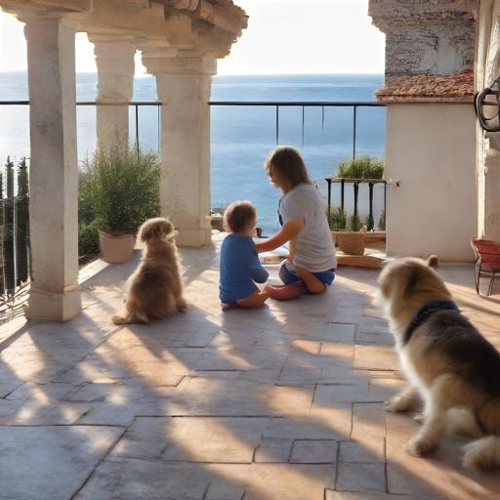

In [16]:
#prompt = "Una casa rústica de paredes altas, con ventanales grandes que den a una terraza con plantas, que la cocina sea americana."

prompt = "Una mansión con vista al mar, con dos niños y un perro jugando en el patio de esta."

# run prediction
response = predictor.predict(data={
  "inputs": prompt,
  "parameters": {
    "num_inference_steps": 1,
    #"num_images_per_prompt": 4,
    "guidance_scale":0.0,
    }
  }
)

# decode and display image
display_image(decode_base64_image(response["generated_images"][0]))